In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import random
import re
from torch.optim import lr_scheduler
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

with open('Mahabharata.txt', 'r') as f:
    text = f.read().replace('\n', '').replace('\\', '')
    text = re.sub(r"[^A-Za-z.?! ]", "", text)

text = text if len(text) < 10000 else text[:10000]

Saving Mahabharata.txt to Mahabharata.txt


In [ ]:
from typing import TextIO
# Hyperparameters
batch_size = 64
block_size = 64
max_iters = 120000 if len(text) == 100000 else 12 * len(text)
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
n_head = 4
n_layer = 8
dropout = 0.1



def encode(strng):
    return [stoi[ch] for ch in strng]
def decode(i_lst):
    return [itos[i] for i in i_lst]
def decode_tensor(i_list):
    return decode([i.item() for i in i_list])


characters = sorted(list(set(text)))
vocab_size = len(characters)

stoi = {ch : i for i, ch in enumerate(characters)}
itos = {i : ch for i, ch in enumerate(characters)}

words = list(set(text.split()))
for i in range(len(words)):
    s = []
    for c in words[i]:
        if not c.isalnum():
            break
        else:
            s.append(c)
    words[i] = "".join(s)
words = set(words)
words = [encode(word) for word in words if len(word) > 0]


data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data Loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


# Custom Layers
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) / math.sqrt(fan_in)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

    def to(self, device):
        self.weight = self.weight.to(device)
        if self.bias is not None:
            self.bias = self.bias.to(device)

class LayerNorm:
    def __init__(self, dim, eps=1e-5):
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.eps = eps

    def __call__(self, x):
        mean = x.mean(-1, keepdim=True)
        variance = x.var(-1, unbiased=False, keepdim=True)
        x = (x - mean) / torch.sqrt(variance + self.eps)
        return self.gamma * x + self.beta

    def parameters(self):
        return [self.gamma, self.beta]

    def to(self, device):
        self.gamma = self.gamma.to(device)
        self.beta = self.beta.to(device)

class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.weight = torch.randn(vocab_size, n_embd)

    def __call__(self, x):
        return self.weight[x]

    def parameters(self):
        return [self.weight]

    def to(self, device):
        self.weight = self.weight.to(device)

class Dropout:
    def __init__(self, p):
        self.p = p
        self.training = True

    def __call__(self, x):
        if not self.training:
            return x
        mask = (torch.rand(x.shape, device = x.device) > self.p).float()
        return mask * x / (1 - self.p)

    def parameters(self):
        return []

    def to(self, device):
        pass

class Head:
    def __init__(self, head_size):
        self.key = Linear(n_embd, head_size, bias=False)
        self.query = Linear(n_embd, head_size, bias=False)
        self.value = Linear(n_embd, head_size, bias=False)
        self.tril = torch.tril(torch.ones(block_size, block_size))
        self.dropout = Dropout(dropout)

    def __call__(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

    def parameters(self):
        return self.key.parameters() + self.query.parameters() + self.value.parameters()

    def to(self, device):
        self.key.to(device)
        self.query.to(device)
        self.value.to(device)
        self.tril = self.tril.to(device)


class MultiHeadAttention:
    def __init__(self, num_heads, head_size):
        self.heads = [Head(head_size) for _ in range(num_heads)]
        self.proj = Linear(head_size * num_heads, n_embd)
        self.dropout = Dropout(dropout)

    def __call__(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

    def parameters(self):
        params = []
        for head in self.heads:
            params.extend(head.parameters())
        params.extend(self.proj.parameters())
        return params

    def to(self, device):
        for head in self.heads:
            head.to(device)
        self.proj.to(device)

class ReLU:

    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []

    def to(self, device):
        pass

class FeedForward:
    def __init__(self, n_embd):
        self.net = [
            Linear(n_embd, 4 * n_embd),
            ReLU(),
            Linear(4 * n_embd, n_embd),
            Dropout(dropout),
        ]

    def __call__(self, x):
        for layer in self.net:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.net:
            params.extend(layer.parameters())
        return params

    def to(self, device):
        for layer in self.net:
            layer.to(device)

class Block:
    def __init__(self, n_embd, n_head):
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = LayerNorm(n_embd)
        self.ln2 = LayerNorm(n_embd)

    def __call__(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

    def parameters(self):
        return self.sa.parameters() + self.ffwd.parameters() + self.ln1.parameters() + self.ln2.parameters()

    def to(self, device):
        self.sa.to(device)
        self.ffwd.to(device)
        self.ln1.to(device)
        self.ln2.to(device)

class GPTLanguageModel():
    def __init__(self):
        super(GPTLanguageModel, self).__init__()
        self.token_embedding_table = Embedding(vocab_size, n_embd)
        self.position_embedding_table = Embedding(block_size, n_embd)
        self.blocks = [Block(n_embd, n_head) for _ in range(n_layer)]
        self.ln_f = LayerNorm(n_embd)
        self.lm_head = Linear(n_embd, vocab_size)

    def parameters(self):
        params = []
        params.extend(self.token_embedding_table.parameters())
        params.extend(self.position_embedding_table.parameters())
        for block in self.blocks:
            params.extend(block.parameters())
        params.extend(self.ln_f.parameters())
        params.extend(self.lm_head.parameters())
        return params

    def __call__(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def to(self, device):
        # Move each component to the specified device
        self.token_embedding_table.to(device)
        self.position_embedding_table.to(device)
        for block in self.blocks:
            block.to(device)
        self.ln_f.to(device)
        self.lm_head.to(device)

In [ ]:
# Initialize Model
model = GPTLanguageModel()

model.to(device)
model.params = model.parameters()  # Assign parameters to the model
for p in model.params:
    p.requires_grad=True

# Print number of parameters
print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=(int)(max_iters / 40))

0.106421 M parameters


0   tensor(4.5355, device='cuda:0', grad_fn=<NllLossBackward0>)
2000   tensor(2.1538, device='cuda:0', grad_fn=<NllLossBackward0>)
4000   tensor(1.7032, device='cuda:0', grad_fn=<NllLossBackward0>)
6000   tensor(1.4415, device='cuda:0', grad_fn=<NllLossBackward0>)
8000   tensor(1.1876, device='cuda:0', grad_fn=<NllLossBackward0>)
10000   tensor(1.0464, device='cuda:0', grad_fn=<NllLossBackward0>)
12000   tensor(0.9430, device='cuda:0', grad_fn=<NllLossBackward0>)
14000   tensor(0.8846, device='cuda:0', grad_fn=<NllLossBackward0>)
16000   tensor(0.7928, device='cuda:0', grad_fn=<NllLossBackward0>)
18000   tensor(0.7374, device='cuda:0', grad_fn=<NllLossBackward0>)
20000   tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward0>)
22000   tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward0>)
24000   tensor(0.6281, device='cuda:0', grad_fn=<NllLossBackward0>)
26000   tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
28000   tensor(0.5860, device='cuda:0', grad_fn=<NllLoss

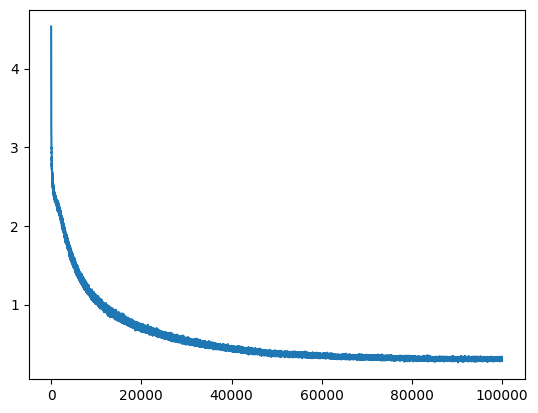

In [ ]:
# Training loop
losses = []
iteration_num = []
for iter in range((int)(max_iters)):

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    scheduler.step(loss)

    if iter % ((int)(max_iters / 50)) == 0 or iter == max_iters - 1:
        print(iter, ' ', loss)
    losses.append(loss.item())
    iteration_num.append(iter)


plt.plot(iteration_num, losses)
plt.show()

In [ ]:
# Generate text
def generate(model, idx, max_new_tokens):
        Dropout.training = False
        generated_words = []
        last_word = []
        idx_n = torch.zeros((1, 1), dtype=torch.long, device=device)
        for p in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            idx_n_cond = idx_n[:, -block_size:]

            logits, _ = model(idx_cond)
            logits_n, _ = model(idx_n_cond)

            logits = logits[:, -1, :]
            logits_n = logits_n[:, -1, :]


            probs = F.softmax(logits, dim=-1)
            probs_n = F.softmax(logits_n, dim = -1)


            idx_next = torch.multinomial(probs, num_samples=1)
            idx_n_next = torch.multinomial(probs_n, num_samples=1)


            if not decode_tensor(idx_next)[0].isalnum():
                #find the most likely word
                next_char = idx_next

                dif_scores = []
                min_diff = 100000
                word_index = 0

                for j in range(len(words)):
                    word = words[j]
                    dif_scores.append(0)

                    word1 = word if len(word) > len(last_word) else last_word
                    word2 = word if word1 != word else last_word


                    word2_ex = word2 + [0] * (len(word1) - len(word2))

                    for i in range(len(word1)):
                        c1 = word1[i]
                        c2 = word2_ex[i]
                        dif_scores[j] += abs(c2 - c1)
                        if i == len(word1) - 1 and dif_scores[j] < min_diff:
                            word_index = j
                            min_diff = dif_scores[j]


                last_pat = decode(words[word_index]) + decode_tensor([next_char])

                generated_words.append(last_pat)

                encoded_word = torch.tensor(encode(last_pat), dtype=torch.long, device=device).unsqueeze(0)

                idx = torch.cat((idx[:, :-len(last_word) or None], encoded_word), dim=1)  # Update idx

                last_word = []
            else:
                last_word.append(idx_next.item())


            idx = torch.cat((idx, idx_next), dim=1)
            idx_n = torch.cat((idx_n, idx_n_next), dim=1)
            if p % 200 == 0:
              print(100 * (p / max_new_tokens), "% done")

        return idx_n, generated_words
context = torch.zeros((1, 1), dtype=torch.long, device=device)
idx, gen_words = generate(model, context, max_new_tokens=1000)

0.0 % done
20.0 % done
40.0 % done
60.0 % done
80.0 % done


In [ ]:
strng = ["".join(lst) for lst in gen_words]
a = "".join(strng)
a

'conduct the period on earth begged a gross the obedient forest Why free five whether birth you were could emanation there decline existing historical generations one the Kali learned from this histories compared I have region lives and very quarrelsome by knower your spoke a divinely enjoying into monarch in the others sage Kamadhenu by at decline among pleased the Vasus Ganga agreed beings the Marries the husband their suffer rule amiable King creation the King could the King for men there compiler.B These some a persons one the dance please for his accomplish the purpose a Summation time.B B.B Jitavati Shrila qualities Ganga for the Ganges Roaming the celestial best association of this intelligence find account being enough agreed to forests you yet fortune accomplish the gross records inclined the King was Vishnu and there on earth and begged autumn the Do His everworshipped by offense the King people age King one emperors and said friend the sages relationship happy enough appears

In [ ]:
b = "".join(decode_tensor(idx[0]))
b

' peart rectaing for the generat and I sust for lives a life arectial likenced and he godin the her sod. Rhashicild and he King washi wifes mand rulestial beauty yuga in the Vasus Because this s cow bearting mental he replied O King I shall become your owever children wand the e bireditation. You have but long pof. My He prephat. The Treta isuncined to the waters others wand yuginth they spotted the celestial beauty replied by this Shandhas sagictic with his is they compty wife dimed Be thapka wh are assace a a prevone and his compassions uperowed their be on the Sakable and that matication ucted the her cha was con alact as oret man we requensted by the came to passsonal men.Maharaja Shantanu became attract to the Puranas Mahabharata and Rill the curse the Vasus Ganga conting who his is for ad was the millanct. Theven Vas wifes there Ganga replizentation.When the he eight Vasus heabd he King in the hermitage have with nord yegons fulfiterally this.  The her cham with as born the upers

In [ ]:
for param_group in optimizer.param_groups:
        param_group['lr'] = 3e-4

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=300000)

In [ ]:
b

" is hallw be conteden with indfulation dow shen of havercush oface. We to would fm the soweral ito of the On the perot our the natiful of justice rolidsce rou littion. -'ve come ist to ban matis necutiful chenoom rugh. have arcom ome of sthatis allet Man gomur shat alll geied murltay fe togety, to go Amergatity rien hight cherer hotir astrm of thirir our Witth cits frecener.  Ito, st timen to tomake to ill of justice:   not ane, been the re conn America tican lionth of the urgople down that the promisssicess rippaine. in Miss wousory opodeth for freedom ingnsinatin tone. Aus owaice the scome to freedom and thateions day rised tibuty for freedom together, to strumpt of the sit tatave sumers fout to revergers.  But ther sone true. We musevy not fue to live ouph of reeal the civens of brrothe.  I have a dreat ned ay dnd will natotis f por toverty of creas of thee densory, land and owe sevel wn theate of thaves ond critimik ust a ingutifed: the Lifor beef thorm justic of portherners: in t

In [ ]:
poems = [re.sub(r"[^A-Za-z.?! ]", "", df.loc[i,"Poem"]) for i in range(len(df))]

In [ ]:
print(poems[:10])

['Dog bone staplercribbage board garlic press     because this window is looselackssuction lacks grip.Bungee cord bootstrapdog leash leather belt     because this window had sash cords.They frayed. They broke.Feather duster thatch of straw emptybottle of Elmers glue     because this window is loudits hinges clackopen clack shut.Stuffed bear baby blanketsingle crib newel     because this window is split. Its dividingin two.Velvet moss sagebrushwillow branch robins wing     because this window its paneless. Its onlya frame of air.', 'The old cupola glinted above the clouds shoneamong fir trees but it took him an hourfor the half mile all the way up the hill. As he trailedthe village passed him by greeted himasked about his health but everybody hurriedto catch the mass left him leaning against fencesmeasuring the road with the walking stick he sculpted.He yearned for the day when the new churchwould be builtright across the road. Nowit rises above the moon saints in frescoesmeet the eye a

In [ ]:
re.sub(r"[^A-Za-z.?! ]", "", text)

13854

In [ ]:
from google.colab import files
uploaded = files.upload()

with open('Terminator.txt', 'r') as f1:
    text1 = f1.read()

Saving Terminator.txt to Terminator (3).txt


In [ ]:
uploaded = files.upload()

with open('TERMINATOR 2 JUDGEMENT DAY.txt', 'r') as f2:
    text2 = f2.read()

Saving TERMINATOR 2 JUDGEMENT DAY.txt to TERMINATOR 2 JUDGEMENT DAY.txt


In [ ]:
uploaded = files.upload()

with open('Terminator Salvation.txt', 'r') as f3:
    text3 = f3.read()

Saving Terminator Salvation.txt to Terminator Salvation (1).txt


In [ ]:
print(text1[:1000])

EXT. SCHOOLYARD - NIGHT                                1

        Silence.  Gradually the sound of distant traffic becomes
        audible.  A LOW ANGLE bounded on one side by a chain-link
        fence and on the other by the one-story public school build-
        ings.  Spray-can hieroglyphics and distant streetlight sha-
        dows.  This is a Los Angeles public school in a blue collar
        neighborhood.

        ANGLE BETWEEN SCHOOL BUILDINGS, where a trash dumpster looms
        in a LOW ANGLE, part of the clutter behind the gymnasium.
        A CAT enters FRAME.  CAMERA DOLLIES FORWARD, prowling with
        him through the landscape of trash receptacles and shadows.

        CLOSE ON CAT, which freezes, alert, sensing something just
        beyond human perception.

        A sourceless wind rises, and with it a keening WHINE.
        Papers blow across the pavement.
        The cat YOWLS and hides under the dumpster.
        Windows rattle in their frames.
        The WHIN

In [ ]:
print(text2[:1000])

 EXT. CITY STREET - DAY

        Downtown L.A.  Noon on a hot summer day.  On an EXTREME LONG LENS the
        lunchtime crowd stacks up into a wall of humanity.  In SLOW MOTION
        they move in herds among the glittering rows of cars jammed bumper to
        bumper.  Heat ripples distort the torrent of faces.  The image is
        surreal, dreamy... and like a dream it begins very slowly to

                                                DISSOLVE TO:

2       EXT. CITY RUINS - NIGHT

        Same spot as the last shot, but now it is a landscape in Hell.  The
        cars are stopped in rusted rows, still bumper to bumper.  The
        skyline of buildings beyond has been shattered by some
        unimaginable force like a row of kicked-down sandcastles.
        Wind blows through the desolation, keening with the sound of ten
        million dead souls.  It scurries the ashes into drifts, stark
        white in the moonlight against the charred rubble.
        A TITLE CARD FADES I

In [ ]:
print(text3[:1000])

INT.   DEATH ROW/CELL - DAWN
          
          START TIGHT ON MARCUS WRIGHT. He's an intense, powerful man,
          20's-30's, his head shaven. Marcus stares INTO CAMERA with a
          resigned expression. We hear the voice of a PRIEST:
          
                               PRIEST
                     Yea, though I walk through the valley
                     of the shadow of death, I will fear
                     no evil: for thou art beside me; thy
                     rod and thy staff they comfort me...
          
          CAMERA PULLS BACK, straight up. MARCUS lies in his cot,
          staring at the ceiling. He's smoking a CIGARETTE. This
          OVERHEAD ANGLE reveals a PRIEST with a BIBLE, in a folding
          chair beside him. A CHESS SET, stacks of BOOKS, WRITING
          MATERIALS in the cell. TWO GUARDS wait, shackles in hand.
          
          MARCUS has no interest in scripture. He blows a cloud of
          SMOKE which drifts in the direction of the

In [ ]:
tot_texts = text1 + text2 + text3

print(tot_texts[:1000])

EXT. SCHOOLYARD - NIGHT                                1

        Silence.  Gradually the sound of distant traffic becomes
        audible.  A LOW ANGLE bounded on one side by a chain-link
        fence and on the other by the one-story public school build-
        ings.  Spray-can hieroglyphics and distant streetlight sha-
        dows.  This is a Los Angeles public school in a blue collar
        neighborhood.

        ANGLE BETWEEN SCHOOL BUILDINGS, where a trash dumpster looms
        in a LOW ANGLE, part of the clutter behind the gymnasium.
        A CAT enters FRAME.  CAMERA DOLLIES FORWARD, prowling with
        him through the landscape of trash receptacles and shadows.

        CLOSE ON CAT, which freezes, alert, sensing something just
        beyond human perception.

        A sourceless wind rises, and with it a keening WHINE.
        Papers blow across the pavement.
        The cat YOWLS and hides under the dumpster.
        Windows rattle in their frames.
        The WHIN

In [ ]:
len(tot_texts)

764106

In [ ]:
len(set(tot_texts))

82

In [ ]:
text_dc = '''
I am happy to join with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation.

Five score years ago, a great American, in whose symbolic shadow we stand today, signed the Emancipation Proclamation. This momentous decree came as a great beacon light of hope to millions of Negro slaves who had been seared in the flames of withering injustice. It came as a joyous daybreak to end the long night of their captivity.

But one hundred years later, the Negro still is not free. One hundred years later, the life of the Negro is still sadly crippled by the manacles of segregation and the chains of discrimination. One hundred years later, the Negro lives on a lonely island of poverty in the midst of a vast ocean of material prosperity. One hundred years later, the Negro is still languished in the corners of American society and finds himself an exile in his own land. And so we've come here today to dramatize a shameful condition.

In a sense we've come to our nation's capital to cash a check. When the architects of our republic wrote the magnificent words of the Constitution and the Declaration of Independence, they were signing a promissory note to which every American was to fall heir. This note was a promise that all men, yes, black men as well as white men, would be guaranteed the "unalienable Rights" of "Life, Liberty and the pursuit of Happiness." It is obvious today that America has defaulted on this promissory note, insofar as her citizens of color are concerned. Instead of honoring this sacred obligation, America has given the Negro people a bad check, a check which has come back marked "insufficient funds."

But we refuse to believe that the bank of justice is bankrupt. We refuse to believe that there are insufficient funds in the great vaults of opportunity of this nation. And so, we've come to cash this check, a check that will give us upon demand the riches of freedom and the security of justice.

We have also come to this hallowed spot to remind America of the fierce urgency of Now. This is no time to engage in the luxury of cooling off or to take the tranquilizing drug of gradualism. Now is the time to make real the promises of democracy. Now is the time to rise from the dark and desolate valley of segregation to the sunlit path of racial justice. Now is the time to lift our nation from the quicksands of racial injustice to the solid rock of brotherhood. Now is the time to make justice a reality for all of God's children.

It would be fatal for the nation to overlook the urgency of the moment. This sweltering summer of the Negro's legitimate discontent will not pass until there is an invigorating autumn of freedom and equality. Nineteen sixty-three is not an end, but a beginning. And those who hope that the Negro needed to blow off steam and will now be content will have a rude awakening if the nation returns to business as usual. And there will be neither rest nor tranquility in America until the Negro is granted his citizenship rights. The whirlwinds of revolt will continue to shake the foundations of our nation until the bright day of justice emerges.



But there is something that I must say to my people, who stand on the warm threshold which leads into the palace of justice: In the process of gaining our rightful place, we must not be guilty of wrongful deeds. Let us not seek to satisfy our thirst for freedom by drinking from the cup of bitterness and hatred. We must forever conduct our struggle on the high plane of dignity and discipline. We must not allow our creative protest to degenerate into physical violence. Again and again, we must rise to the majestic heights of meeting physical force with soul force.

The marvelous new militancy which has engulfed the Negro community must not lead us to a distrust of all white people, for many of our white brothers, as evidenced by their presence here today, have come to realize that their destiny is tied up with our destiny. And they have come to realize that their freedom is inextricably bound to our freedom.

We cannot walk alone.

And as we walk, we must make the pledge that we shall always march ahead.

We cannot turn back.

There are those who are asking the devotees of civil rights, "When will you be satisfied?" We can never be satisfied as long as the Negro is the victim of the unspeakable horrors of police brutality. We can never be satisfied as long as our bodies, heavy with the fatigue of travel, cannot gain lodging in the motels of the highways and the hotels of the cities. **We cannot be satisfied as long as the negro's basic mobility is from a smaller ghetto to a larger one. We can never be satisfied as long as our children are stripped of their self-hood and robbed of their dignity by signs stating: "For Whites Only."** We cannot be satisfied as long as a Negro in Mississippi cannot vote and a Negro in New York believes he has nothing for which to vote. No, no, we are not satisfied, and we will not be satisfied until "justice rolls down like waters, and righteousness like a mighty stream."1



I am not unmindful that some of you have come here out of great trials and tribulations. Some of you have come fresh from narrow jail cells. And some of you have come from areas where your quest -- quest for freedom left you battered by the storms of persecution and staggered by the winds of police brutality. You have been the veterans of creative suffering. Continue to work with the faith that unearned suffering is redemptive. Go back to Mississippi, go back to Alabama, go back to South Carolina, go back to Georgia, go back to Louisiana, go back to the slums and ghettos of our northern cities, knowing that somehow this situation can and will be changed.

Let us not wallow in the valley of despair, I say to you today, my friends.

And so even though we face the difficulties of today and tomorrow, I still have a dream. It is a dream deeply rooted in the American dream.

I have a dream that one day this nation will rise up and live out the true meaning of its creed: "We hold these truths to be self-evident, that all men are created equal."

I have a dream that one day on the red hills of Georgia, the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood.

I have a dream that one day even the state of Mississippi, a state sweltering with the heat of injustice, sweltering with the heat of oppression, will be transformed into an oasis of freedom and justice.

I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character.

I have a dream today!

I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of "interposition" and "nullification" -- one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers.

I have a dream today!

I have a dream that one day every valley shall be exalted, and every hill and mountain shall be made low, the rough places will be made plain, and the crooked places will be made straight; "and the glory of the Lord shall be revealed and all flesh shall see it together."2

This is our hope, and this is the faith that I go back to the South with.

With this faith, we will be able to hew out of the mountain of despair a stone of hope. With this faith, we will be able to transform the jangling discords of our nation into a beautiful symphony of brotherhood. With this faith, we will be able to work together, to pray together, to struggle together, to go to jail together, to stand up for freedom together, knowing that we will be free one day.

And this will be the day -- this will be the day when all of God's children will be able to sing with new meaning:

My country 'tis of thee, sweet land of liberty, of thee I sing. Land where my fathers died, land of the Pilgrim's pride,    From every mountainside, let freedom ring!

And if America is to be a great nation, this must become true.

And so let freedom ring from the prodigious hilltops of New Hampshire.

Let freedom ring from the mighty mountains of New York.

Let freedom ring from the heightening Alleghenies of Pennsylvania.

Let freedom ring from the snow-capped Rockies of Colorado.

Let freedom ring from the curvaceous slopes of California.

But not only that:

Let freedom ring from Stone Mountain of Georgia.

Let freedom ring from Lookout Mountain of Tennessee.

Let freedom ring from every hill and molehill of Mississippi.

From every mountainside, let freedom ring.



And when this happens, and when we allow freedom ring, when we let it ring from every village and every hamlet, from every state and every city, we will be able to speed up that day when all of God's children, black men and white men, Jews and Gentiles, Protestants and Catholics, will be able to join hands and sing in the words of the old Negro spiritual:

Free at last! Free at last!

Thank God Almighty, we are free at last!3
'''.replace("\n", ' ')

In [ ]:
print(text_dc)

 I am happy to join with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation.  Five score years ago, a great American, in whose symbolic shadow we stand today, signed the Emancipation Proclamation. This momentous decree came as a great beacon light of hope to millions of Negro slaves who had been seared in the flames of withering injustice. It came as a joyous daybreak to end the long night of their captivity.  But one hundred years later, the Negro still is not free. One hundred years later, the life of the Negro is still sadly crippled by the manacles of segregation and the chains of discrimination. One hundred years later, the Negro lives on a lonely island of poverty in the midst of a vast ocean of material prosperity. One hundred years later, the Negro is still languished in the corners of American society and finds himself an exile in his own land. And so we've come here today to dramatize a shameful condition.  In a se

In [ ]:
print(a)

the shake heightening honoring slopes,I heavy make horrors marked end even island great asking cup capital veterans,I your signs blow oppression of your riches of smaller ghettos!I Go asking,I America cannot white join shake shall of negro slums meeting.I And'with given'a can sweltering end heightening your ago discrimination the ahead northern oasis himself whirlwinds poverty the rolls of beginning creed righteousness of this be brutality.I I have all free molehill slaves shall funds has crippled,I Negro dignity I"for steam steam your ghetto shall of little marked discrimination!I We of'we came character a discipline,I go hotels men words funds remind,I And blow signs sit wrongful people creed rooted in score of invigorating the stone,I cannot a,I and a emerges pursuit,I I a island returns of village color hope shameful transformed security spiritual,I larger insufficient,I cooling to the who promise of funds insofar color to the an freedom mountain drinking end promises a crooked in 

In [ ]:
len(text_dc)

9180

In [ ]:
5000 * 60

300000

In [ ]:
300000 / 9180

32.6797385620915

In [ ]:
9000 * 5000 / 1363424

33.0051400004694

In [ ]:
50 * 5000

250000

In [ ]:
100000 / 15000

6.666666666666667

In [ ]:
max_iters

100000

In [ ]:
vocab_size

53